<a href="https://colab.research.google.com/github/vinayprabhu/hate_scaling/blob/main/code/1b_CFD_examples_worsening.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GOAL

Examples (with images) for the paper where the cosine-sim wrt an offensive class (like criminal) increases with dataset scaling.

# STEP-0: The basic imports + colab boiler-plate + mounting the directory

In [1]:
import numpy as np
import os
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm
import pickle

from scipy.linalg import block_diag
# Don't do linear algebra in Python without these two lines
np.set_printoptions(suppress=True)
from collections import Counter
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

import torch

import skimage
import IPython.display
from PIL import Image
from collections import OrderedDict
import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#############################################
import sys
import importlib
importlib.reload(sys)
#######################
from google.colab import drive
drive.flush_and_unmount()
import os
drive.mount('/gdrive', force_remount=True)
# Enter your own proj_dir here
proj_dir='/gdrive/My Drive/Colab Notebooks/0_scale_paper/' # SET YOUR DRIVE DIRECTORY HERE
os.chdir(proj_dir)

<ipython-input-1-9ea2d91f362c>:15: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


Mounted at /gdrive


# Step-1: CFD PREPPING

Download the dataset from https://www.chicagofaces.org/ and unzip it in a local sub-dir as:

```
os.makedirs('./cfd/')
import zipfile
with zipfile.ZipFile('cfd_3_0.zip', 'r') as zip_ref:
    zip_ref.extractall('./cfd')


```
NOTE: You'll have to fill out a request form available [here](https://www.chicagofaces.org/download/).

Background:

- CFD : "The main CFD set consists of images of 597 unique individuals. They include self-identified Asian,
Black, Latino, and White female and male models, recruited in the United States. All models are
represented with neutral facial expressions. A subset of the models is also available with varying facial
expressions. Norming data are available for all neutral expression images. Subjective rating norms are
based on a U.S. rater sample".

The CFD family also has:

- CFD-MR (images of 88 unique individuals, who self-reported multiracial ancestry)

- CFD-INDIA:( images of 142 unique individuals, recruited in Delhi, India ).

- Paper: https://www.wittenbrink.org/cfd/mcw2015.pdf

In [2]:
cfd_dir='./cfd/CFD Version 3.0/Images/CFD/'

In [3]:
# Read the description file from our github repo
file_cfd_loc='https://raw.githubusercontent.com/vinayprabhu/hate_scaling/main/data/cfd/df_cfd3.csv'
df_cfd=pd.read_csv(file_cfd_loc)
dict_rg={'AF': 'asian woman',
         'AM':'asian man',
         'BF': 'black woman',
         'BM': 'black man',
         'LF': 'latina woman',
         'LM': 'latino man',
         'WF': 'white woman',
         'WM': 'white man'}
df_cfd.replace({'r_g':dict_rg}, inplace=True)
df_cfd.head(2)

,person_id,n_images,img_neutral,r_g,race,gender
0,AF-200,1.0,CFD-AF-200-228-N.jpg,asian woman,A,F
1,AF-201,1.0,CFD-AF-201-060-N.jpg,asian woman,A,F


 Now, let us look at some examplar images and descriptive statistics to give you a good idea about the dataset.

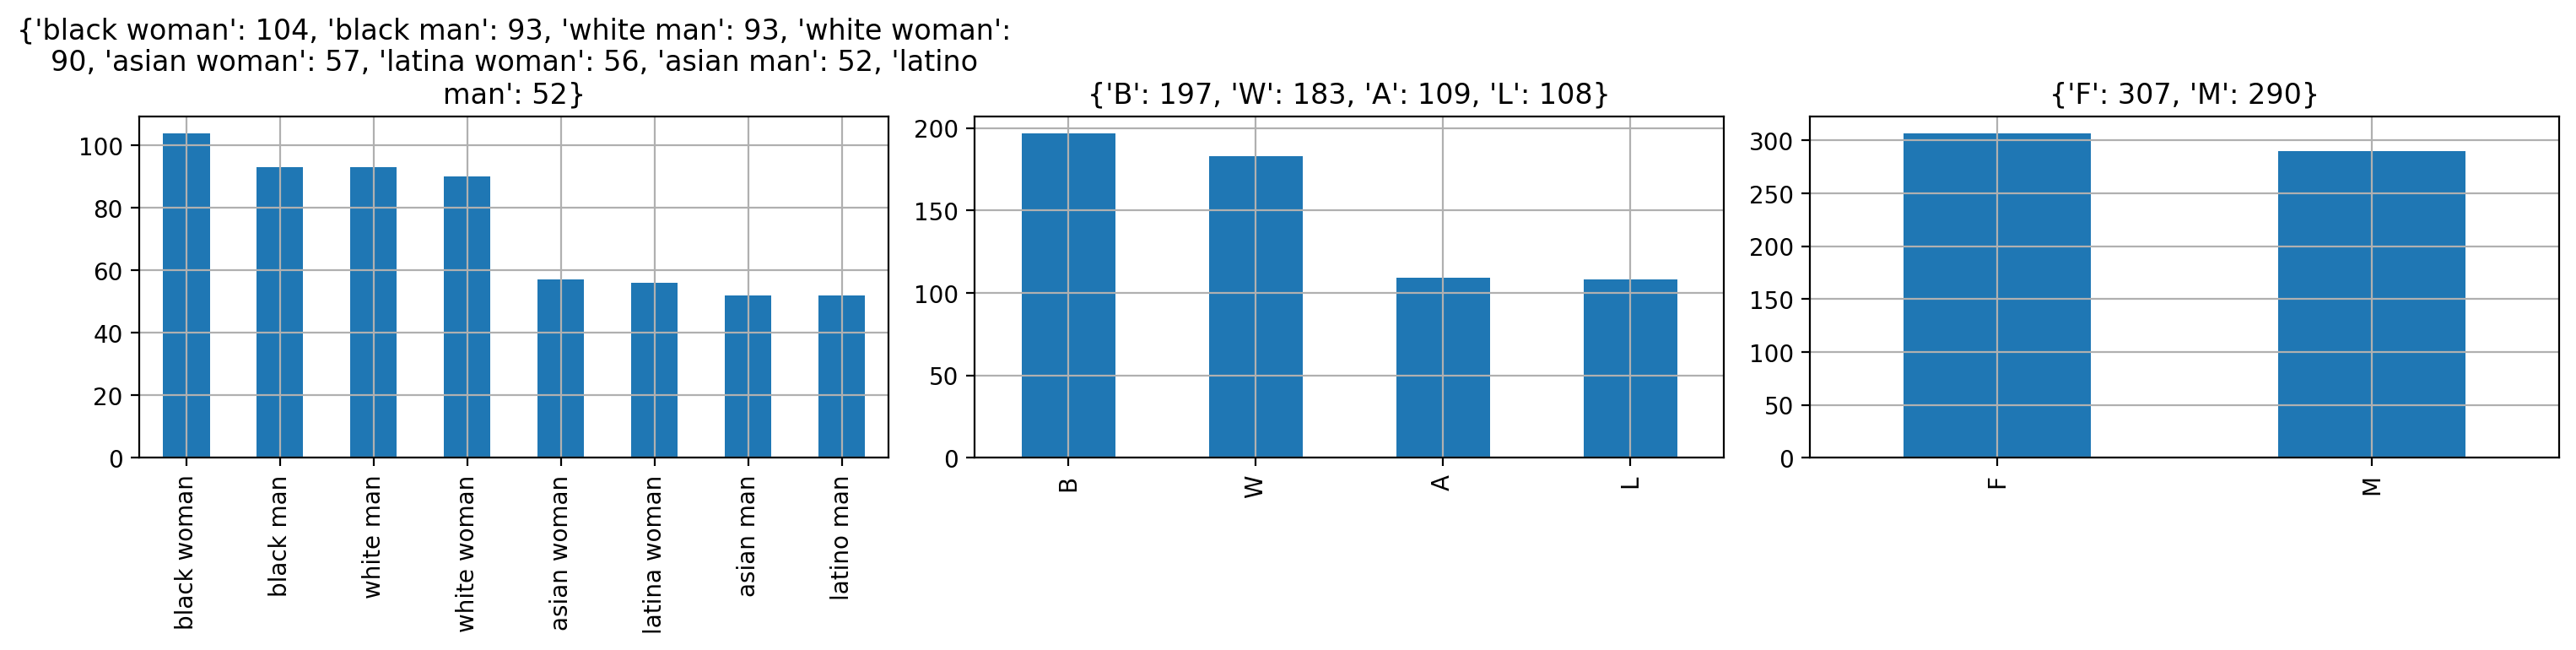

In [4]:
plt.figure(figsize=(15,4))
plt.subplot(131)
df_cfd.r_g.value_counts().plot(kind='bar')
from textwrap import wrap
plt.title("\n".join(wrap(str(dict(df_cfd.r_g.value_counts())))))
plt.grid('On')
plt.subplot(132)
df_cfd.race.value_counts().plot(kind='bar')
plt.title(str(dict(df_cfd.race.value_counts())))
plt.grid('On')
plt.subplot(133)
df_cfd.gender.value_counts().plot(kind='bar')
plt.title(str(dict(df_cfd.gender.value_counts())))
plt.grid('On')
plt.tight_layout()

In [5]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
###################################################
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')
######################################################

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8779080886902509425
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 13810597888
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15407621044285764702
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]
Wed Jun 21 23:02:43 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  T

# 1: Download the cosine and softmax matrices

In [6]:
url_cosine='https://github.com/vinayprabhu/hate_scaling/raw/main/data/cfd/dict_cosine_cfd_vitl14_humanexp.pkl'
dict_cosine_cfd_vitl14_humanexp = pd.read_pickle(url_cosine)

url_softmax='https://github.com/vinayprabhu/hate_scaling/raw/main/data/cfd/dict_softmax_cfd_vitl14_humanexp.pkl'
dict_softmax_cfd_vitl14_humanexp = pd.read_pickle(url_softmax)


c_400m=dict_cosine_cfd_vitl14_humanexp['cfd_ViT-L-14|laion400m_e32']
c_2b=dict_cosine_cfd_vitl14_humanexp['cfd_ViT-L-14|laion2b_s32b_b82k']

s_400m=dict_softmax_cfd_vitl14_humanexp['cfd_ViT-L-14|laion400m_e32']
s_2b=dict_softmax_cfd_vitl14_humanexp['cfd_ViT-L-14|laion2b_s32b_b82k']

# 2: Plot the example images with their softmax/cosine-distance values obtained with the 400M model and the 2B-en model:

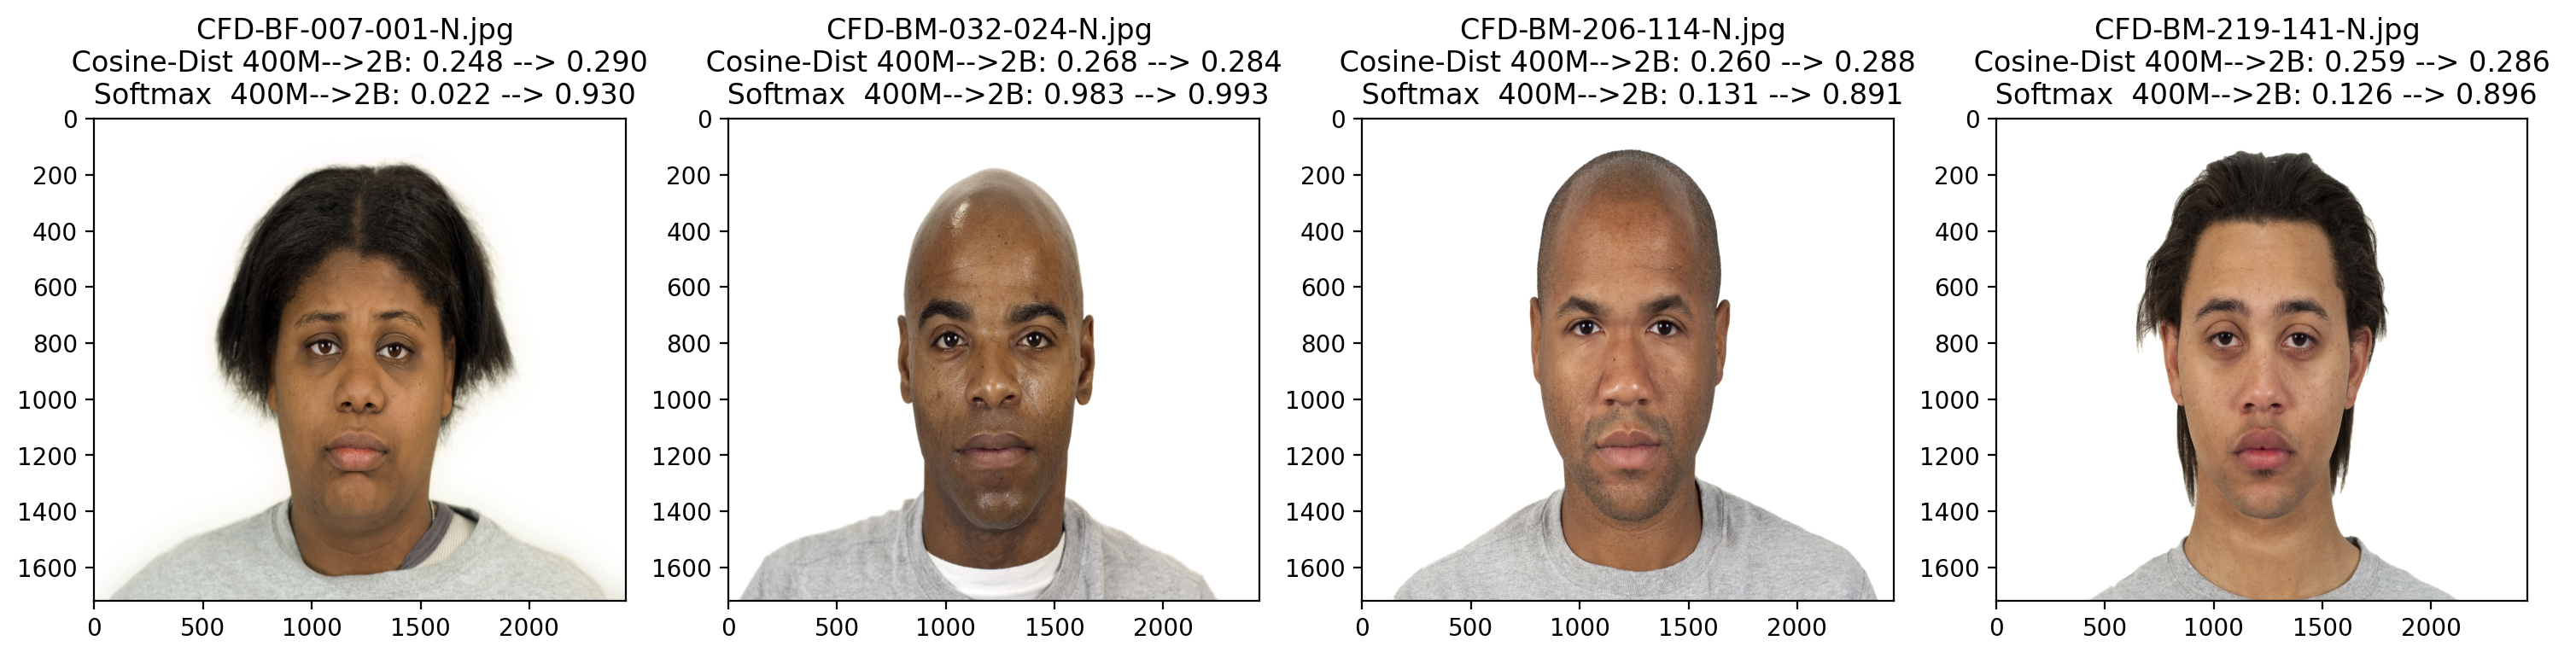

In [8]:

import matplotlib.image as mpimg
index_examples=[115, 240, 259, 272]
col_chosen=6 # Mapping to the Criminal class
plt.figure(figsize=(15,4))
for i in range(4):
  ind_i=index_examples[i]
  title_i=f'{df_cfd.img_neutral[ind_i]} \n Cosine-Dist 400M-->2B: {c_400m[ind_i,col_chosen]:.3f} --> {c_2b[ind_i,col_chosen]:.3f} \n Softmax  400M-->2B: {s_400m[ind_i,col_chosen]:.3f} --> {s_2b[ind_i,col_chosen]:.3f}'
  plt.subplot(1,4,i+1)
  img_i=f"{cfd_dir}{df_cfd.person_id[ind_i]}/{df_cfd.img_neutral[ind_i]}"
  plt.imshow(mpimg.imread(img_i),aspect='auto')
  plt.title(title_i)
plt.tight_layout()